In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from openquake.hazardlib.scalerel.leonard2014 import Leonard2014_Interplate
from openquake.hazardlib.source.rupture import ParametricProbabilisticRupture
from openquake.hazardlib.source.simple_fault import SimpleFaultSource
from openquake.hazardlib.geo.surface import KiteSurface, SimpleFaultSurface, PlanarSurface
from openquake.hazardlib.tom import PoissonTOM
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.geo import Line

from openquake.hazardlib.sourcewriter import write_source_model
from openquake.hazardlib.nrml import SourceModel

In [2]:
def make_surface_from_trace(trace, props, mesh_spacing=5):
    tr = Line([Point(*cc) for cc in trace])
    
    surf = SimpleFaultSurface.from_fault_data(tr, upper_seismogenic_depth=props["usd"],
                                              lower_seismogenic_depth=props["lsd"],
                                              dip=props["dip"],
                                              mesh_spacing=mesh_spacing)
    
    return surf

In [3]:
def make_rup(feature, rake=90., mesh_spacing=5, trt="Active Shallow Crust"):
    surf = make_surface_from_trace(feature['geometry']['coordinates'],
                                   feature['properties'], mesh_spacing=mesh_spacing)
    Mw = feature['properties']['Mw'] or Leonard2014_Interplate().get_median_mag(surf.get_area(), rake)
    
    #if feature['properties']['name'] == '1762_arakan':
    #    trt = "Subduction Interplate"
    #if feature['properties']['trt'] == 'subd':
    #    trt = 'Subduction Interplate'
    #elif feature['properties']['trt'] == 'scr':
    #    trt = 'Stable Continental'
    #else:
    #    raise ValueError(f"{feature['properties']['trt']} not currently an option")
    trt = feature['properties']['trt']
    
    rup = ParametricProbabilisticRupture(Mw, rake, trt, surf.get_hypo_location(mesh_spacing), surf,
                                         1.0, PoissonTOM(1.0))
    
    print(feature['properties']['name'], Mw)
    
    return rup

In [8]:
with open("./scenario_rupture_traces.geojson", "r") as f:
    rj = json.load(f)

In [9]:
rups = [make_rup(f) for f in rj['features']]

western_deformation_front 8.500375503544657
1897_Dauki 8.7
chittagong_north 8.241288688181344
1762_arakan 8.5
sikkim_mht 8.465549697550333
1885_manikganj 7.252248081621123
chittagong_thrust_smaller 7.380065461945215
western_deformation_front_partial 7.705770776851082
1918_Srimangal 7.4
1664_N_Bang 7.7
1822 7.1
1869_cachar 7.311935381119537


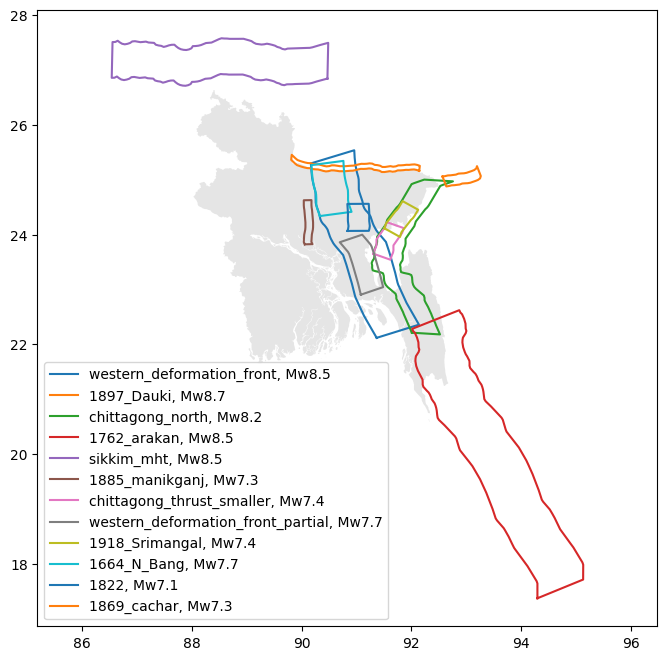

In [10]:
plt.figure(figsize=(8,8))
plt.axis("equal")

try:
    with open("../gis/bangladesh_borders.geojson") as f:
        bj = json.load(f)
    for poly in bj["features"][0]["geometry"]["coordinates"]:
        for lin_ring in poly:
            patch = Polygon(lin_ring, fill=True, facecolor="grey", edgecolor="none", alpha=0.2)
            plt.gca().add_patch(patch)
except:
    pass
                
            

for i, rup in enumerate(rups):
    plt.plot(*rup.surface.get_surface_boundaries(),
            label=rj['features'][i]['properties']['name'] + f", Mw{rup.mag:.1f}")
    
plt.legend(loc='lower left')

In [11]:
import io
import sys

from openquake.hazardlib.sourcewriter import (build_rupture_node)

from openquake.baselib.node import (
    node_to_xml, Node, floatformat)

F64 = np.float64
NAMESPACE = 'http://openquake.org/xmlns/nrml/0.4'
NRML05 = 'http://openquake.org/xmlns/nrml/0.5'
GML_NAMESPACE = 'http://www.opengis.net/gml'
SERIALIZE_NS_MAP = {None: NAMESPACE, 'gml': GML_NAMESPACE}
PARSE_NS_MAP = {'nrml': NAMESPACE, 'gml': GML_NAMESPACE}

def nwrite(nodes, output=sys.stdout, fmt='%.7E', gml=True, xmlns=None):
    """
    Convert nodes into a NRML file. output must be a file
    object open in write mode. If you want to perform a
    consistency check, open it in read-write mode, then it will
    be read after creation and validated.
    :params nodes: an iterable over Node objects
    :params output: a file-like object in write or read-write mode
    :param fmt: format used for writing the floats (default '%.7E')
    :param gml: add the http://www.opengis.net/gml namespace
    :param xmlns: NRML namespace like http://openquake.org/xmlns/nrml/0.4
    """
    root = Node('nrml', nodes=nodes)
    namespaces = {xmlns or NRML05: ''}
    if gml:
        namespaces[GML_NAMESPACE] = 'gml:'
    with floatformat(fmt):
        node_to_xml(root, output, namespaces)
    if hasattr(output, 'mode') and '+' in output.mode:  # read-write mode
        output.seek(0)
        read(output)  # validate the written file
        
        
        
def rups_to_file(rups, outfile):
    nodes = [build_rupture_node(rup, probs_occur=[1.]) for rup in rups]
    
    with open(outfile, 'w') as ff:
        bs = io.BytesIO()
        nwrite(nodes, output=bs)
        ff.write(bs.getvalue().decode("utf-8"))
        
def rup_to_file(rup, outfile):
    # Determine geometry
    geom = rup.surface.surface_nodes[0].tag
    #name = ""
    #if len(rup.surface.surface_nodes) > 1:
    #    name = 'multiPlanesRupture'
    #elif geom == 'planarSurface':
    #    name = 'singlePlaneRupture'
    #elif geom == 'simpleFaultGeometry':
    #    name = 'simpleFaultRupture'
    #elif geom == 'complexFaultGeometry':
    #    name = 'complexFaultRupture'
    #elif geom == 'griddedSurface':
    #    name = 'griddedRupture'
    #elif geom == 'kiteSurface':
    #    name = 'kiteSurface'
    name = "simpleFaultRupture"
    # Arrange node
    h = rup.hypocenter
    hp_dict = dict(lon=h.longitude, lat=h.latitude, depth=h.depth)
    geom_nodes = [Node('magnitude', {}, rup.mag),
                    Node('rake', {}, rup.rake),
                    Node('hypocenter', hp_dict)]
    geom_nodes.extend(rup.surface.surface_nodes)
    rupt_nodes = [Node(name, nodes=geom_nodes)]
    node = Node('nrml', nodes=rupt_nodes)
    # Write file
    with open(outfile, 'w') as ff:
        bs = io.BytesIO()
        nwrite(node, output=bs)
        ff.write(bs.getvalue().decode("utf-8"))

In [12]:
#rups_to_file(rups, "./bangladesh_scenario_ruptures.xml")

In [13]:
for i, rup in enumerate(rups):
    name = rj['features'][i]['properties']['name']
    rup_to_file(rup, f"./bangladesh_{name}_scenario_rupture.xml")